In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
import seaborn as sns
import random

# Looking at Data

In [2]:
df = pd.read_csv('Brstdata_Distant_5064.csv')

In [3]:
df.head(1)

,P.no,surv.mo,death,cause.death,race_black,race_asian,luminal_b,her2_enrch,unkn,tripl_neg
0,1,4,1,Breast Cancer,0,0,1,0,0,0


In [4]:
#df.info()

In [5]:
df = df.drop(columns='P.no') #patient id column, irrelevant

In [6]:
#Revealing hidden race and lum-A column

df['race_white'] = 0
df.loc[(df['race_asian'] == 0) & (df['race_black'] == 0), 'race_white'] = 1


In [7]:
#df.head()

In [8]:
df['luminal_a'] = 0
df.loc[(df['luminal_b'] == 0) & (df['her2_enrch'] == 0) & (df['unkn'] == 0) & (df['tripl_neg'] == 0), 'luminal_a'] = 1

In [9]:
df.head(1)

,surv.mo,death,cause.death,race_black,race_asian,luminal_b,her2_enrch,unkn,tripl_neg,race_white,luminal_a
0,4,1,Breast Cancer,0,0,1,0,0,0,1,0


# Cox Proportional Hazards Model

In [13]:
#Separating data_x (other covariates) and data_y (survival time and death status)
#ONLY considering patients that are Alive or cause death = Breast Cancer for simplicity......

In [14]:
filtered_df = df[(df['cause.death'] == 'Breast Cancer') | (df['cause.death'] == 'Alive')]

In [15]:
filtered_df = filtered_df.drop(columns='cause.death')

In [16]:
data_y = filtered_df[['death', 'surv.mo']]
data_y['death'] = data_y['death'].astype('bool')
#data_y = data_y.to_numpy()

/tmp/ipykernel_54/947950268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_y['death'] = data_y['death'].astype('bool')


In [17]:
#data_y.shape

In [18]:
data_x = filtered_df.drop(columns=['death', 'surv.mo']) #'cause.death']) #'luminal_b','her2_enrch','unkn','tripl_neg','luminal_a']) #for now, will not consider CoD for simplicity

In [19]:
dtype = [('boolean', 'bool'), ('numbers', 'i4')]  #'i4' for 4-byte integer

#turn the dataframe to a structured array
data_y = np.array(list(zip(filtered_df['death'], filtered_df['surv.mo'])), dtype=dtype) 

#print(structured_array)

In [20]:
data_x.shape

(1472, 8)

In [21]:
data_y.shape

(1472,)

In [22]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
#set_config(display="text")

estimator = CoxPHSurvivalAnalysis()                          
estimator.fit(data_x, data_y)

/home/t-movaghar/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.45799e-17): result may not be accurate.
  delta = solve(
/home/t-movaghar/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=6.35985e-17): result may not be accurate.
  delta = solve(


CoxPHSurvivalAnalysis()

In [23]:
pd.Series(estimator.coef_, index=data_x.columns) #Each value corresponds to the hazard ratio..

race_black    2.621957
race_asian    1.963636
luminal_b     1.853752
her2_enrch    2.075446
unkn          2.672340
tripl_neg     2.616417
race_white    2.107456
luminal_a     2.161677
dtype: float64

In [24]:
data_x.head(1)

,race_black,race_asian,luminal_b,her2_enrch,unkn,tripl_neg,race_white,luminal_a
0,0,0,1,0,0,0,1,0


In [25]:
x_new = pd.DataFrame.from_dict(
    {
        1: [0, 1, 0, 1, 0, 0, 0, 0], #Putting together 4 synthetic patients
        2: [1, 0, 0, 0, 0, 0, 0, 1],
        3: [0, 0, 1, 0, 0, 0, 1, 0],
        4: [1, 0, 0, 0, 0, 1, 0, 0],
    },
    columns=data_x.columns,
    orient="index",
)
#x_new

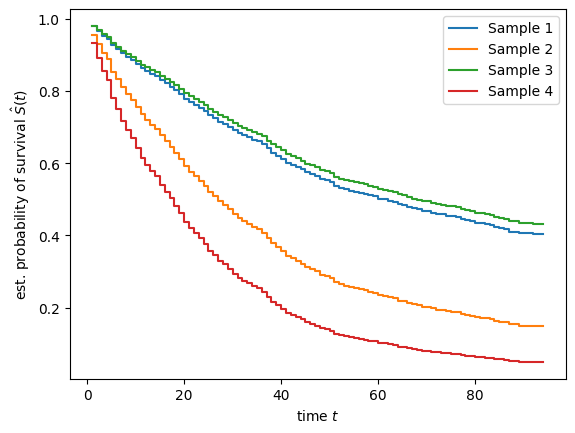

In [26]:
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 95)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [27]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["boolean"], data_y["numbers"], prediction)
result[0]

0.6043523595075774

In [28]:
#models c-index ^^

# Creating KM Curves and Other Visuals

In [29]:
data_y = df[['death', 'surv.mo']]
data_y['death'] = data_y['death'].astype('bool')
#data_y = data_y.to_numpy()

data_x = df.drop(columns=['death', 'surv.mo','cause.death']) #'luminal_b','her2_enrch','unkn','tripl_neg','luminal_a']) #for now, will not consider CoD for simplicity

/tmp/ipykernel_54/1677378629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_y['death'] = data_y['death'].astype('bool')


In [30]:
def plot_kaplan_meier(data_x, data_y, cancer_columns): #SCIKIT SURVIVAL GUIDE: https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html
    for cancer_type in cancer_columns:
        mask = data_x[cancer_type] == 1
        
        #KM estimator
        time_cancer, survival_prob_cancer, conf_int = kaplan_meier_estimator(
            data_y["death"][mask], data_y["surv.mo"][mask], conf_type="log-log")
        #survival curve
        plt.step(time_cancer, survival_prob_cancer, where="post", label=f"{cancer_type} (n = {mask.sum()})")
        #confidence interval
        plt.fill_between(time_cancer, conf_int[0], conf_int[1], alpha=0.05, step="post")
        
    plt.ylim(0, 1)
    plt.ylabel(r"Estimated probability of survival $\hat{S}(t)$")
    plt.xlabel("Time $t$")
    plt.legend(loc="best")
    plt.title("Kaplan-Meier Survival Curves by Type")
    plt.show()


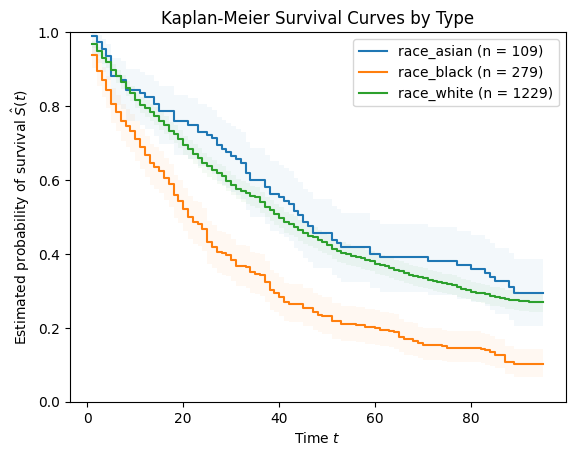

In [31]:
race_columns = ['race_asian', 'race_black', 'race_white']
plot_kaplan_meier(data_x, data_y, race_columns)

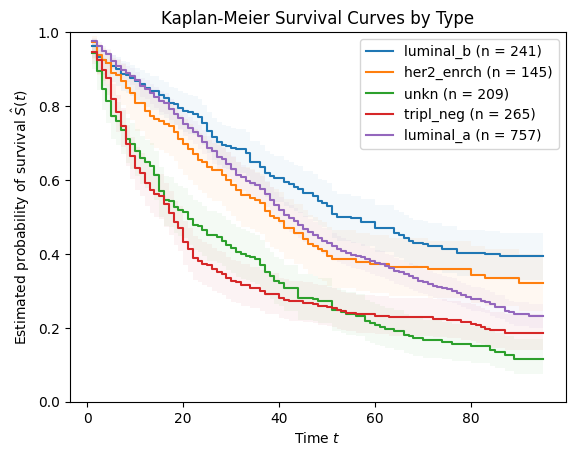

In [32]:
cancer_columns = ['luminal_b', 'her2_enrch', 'unkn', 'tripl_neg','luminal_a']
plot_kaplan_meier(data_x, data_y, cancer_columns)

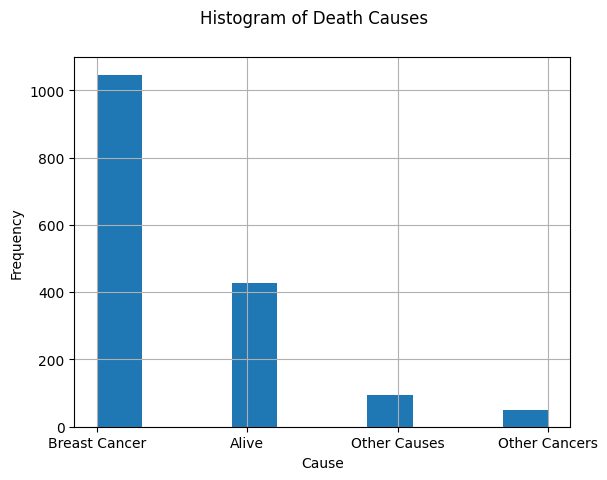

In [33]:
df['cause.death'].hist()
plt.suptitle('Histogram of Death Causes')
plt.xlabel('Cause')
plt.ylabel('Frequency')
#plt.tight_layout()
plt.show()

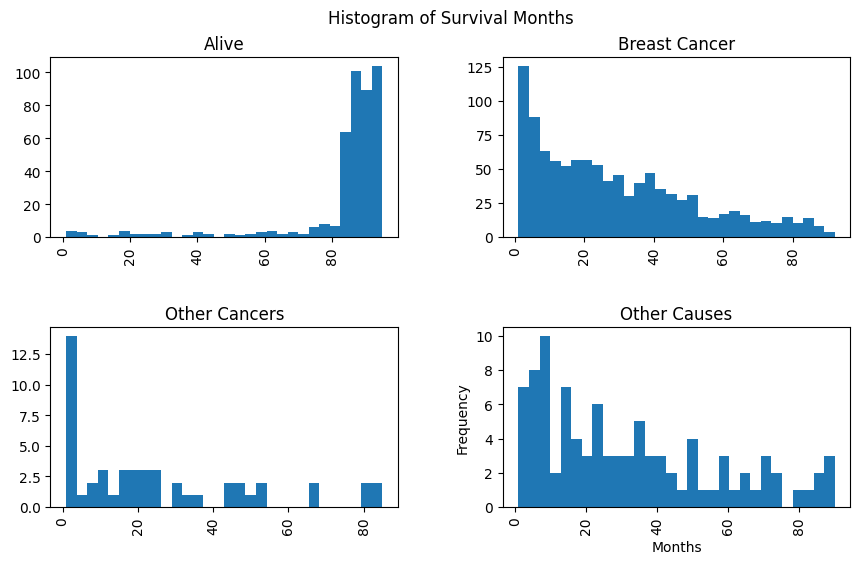

In [11]:
df.hist(column='surv.mo', by='cause.death',figsize=(10, 6), bins=30)
plt.suptitle('Histogram of Survival Months')
plt.xlabel('Months')
plt.ylabel('Frequency')
#plt.tight_layout()
plt.show()

In [12]:
df['cause.death'].value_counts()

cause.death
Breast Cancer    1046
Alive             426
Other Causes       95
Other Cancers      50
Name: count, dtype: int64

In [15]:
#Unencoding for easier visual creation
race_columns = ['race_asian', 'race_black', 'race_white']
cancer_columns = ['luminal_b', 'her2_enrch', 'unkn', 'tripl_neg','luminal_a']

df_uncoded = df.copy()
df_uncoded['race'] = np.select(
    [df_uncoded['race_white'] == 1, df_uncoded['race_black'] == 1, df_uncoded['race_asian'] == 1],
    ['white', 'black', 'asian'])

df_uncoded.drop(columns=race_columns, inplace=True)

df_uncoded['cancer'] = np.select(
    [df_uncoded['luminal_b'] == 1, df_uncoded['her2_enrch'] == 1, df_uncoded['unkn'] == 1,df_uncoded['tripl_neg'] == 1,df_uncoded['luminal_a'] == 1],
    ['luminal_b', 'her2_enrch', 'unkn','tripl_neg','luminal_a'])

df_uncoded.drop(columns=cancer_columns, inplace=True)

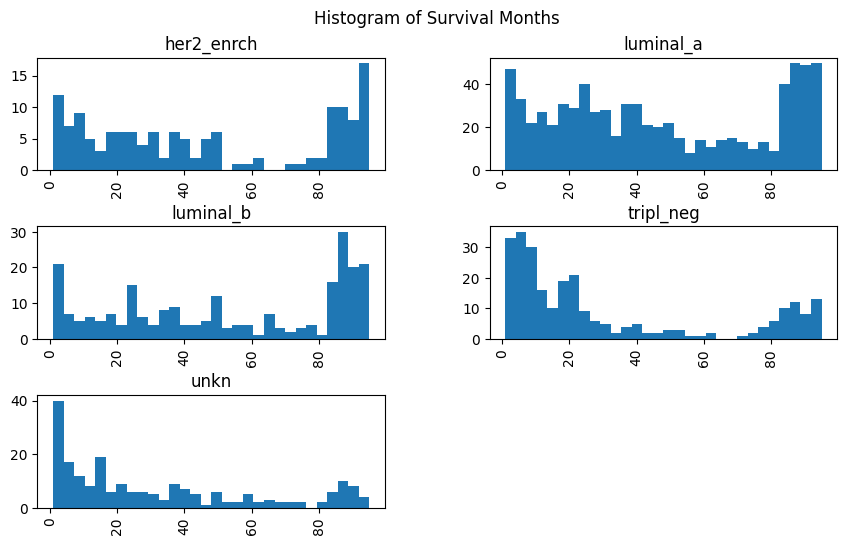

In [18]:
df_uncoded.hist(column='surv.mo', by='cancer',figsize=(10, 6), bins=30)
plt.suptitle('Histogram of Survival Months')
plt.xlabel('Months')
plt.ylabel('Frequency')
#plt.tight_layout()
plt.show()

In [19]:
#df_uncoded
df_uncoded = df_uncoded[df_uncoded['cause.death'] == 'Breast Cancer' ] #Looking at death by breast cancer statistics.

In [20]:
statistics = df_uncoded.groupby('race')['surv.mo'].agg(['mean', 'median']).reset_index()
print(statistics)

    race       mean  median
0  asian  30.224138    28.5
1  black  24.598131    19.0
2  white  30.060724    25.0


In [21]:
statistics = df_uncoded.groupby('cancer')['surv.mo'].agg(['mean', 'median']).reset_index()
print(statistics)

       cancer       mean  median
0  her2_enrch  26.761905    23.5
1   luminal_a  34.558282    31.0
2   luminal_b  31.333333    28.0
3   tripl_neg  17.657895    12.0
4        unkn  24.285714    16.0


In [35]:
#pip install lifelines

In [48]:
from lifelines import KaplanMeierFitter

brst_data = pd.read_csv("Brstdata_Distant_5064.csv")

# assign values to a new column 'D' based on 'cause.death' column
brst_data['D'] = brst_data['cause.death'].apply(lambda x: 2 if x == "Other Cancers" else (3 if x == "Other Causes" else (1)))

# initial cure rate
brst_data['J'] = brst_data['cause.death'].apply(lambda x: 1 if x == "Breast Cancer" else 0)
brst_data['Y'] = brst_data['surv.mo'] / 12 # --> months to years

In [49]:
#brst_data['cause.death'].unique()

In [50]:
kmf = KaplanMeierFitter()
kmf.fit(brst_data['Y'], event_observed=brst_data['J'])
#new library: lifelines

# survival probability at the largest uncensored time is the initial guess for cure rate
survival_prob = kmf.survival_function_at_times(brst_data['Y'].max()).values[0]
print("Initial guess for cure rate:", survival_prob)

Initial guess for cure rate: 0.28904936549925275


In [ ]:
#This initial guess is the same as Dr. Pals.

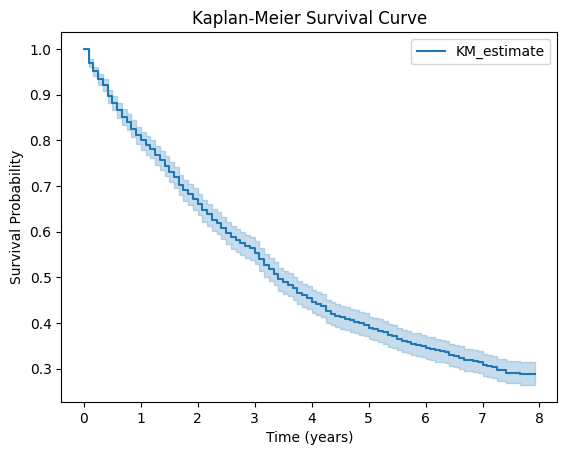

In [51]:
kmf.plot_survival_function()
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curve")
plt.show()

In [1]:
list = pd.DataFrame([1,2,3,4,5,6])
sample = list.sample(5, random_state=42)
sample

NameError: name 'pd' is not defined